In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.tsa.arima.model import ARIMA

# Suppressing warnings
warnings.filterwarnings("ignore")

# Load te data set of coffee shop sales
data_path = '/content/Coffee Shop Sales.csv'
sales_data = pd.read_csv(data_path)

# Step 1: Data Cleaning

# Display the first few rows of the data set
sales_data.head()

sales_data.describe()

# Check data types
data_types = sales_data.dtypes
print(data_types)

# Check for missing values
missing_values = sales_data.isnull().sum()
print(missing_values)

# Check for duplicates
sales_data.duplicated().sum()

# Converting data types for consistency
sales_data['transaction_qty'] = pd.to_numeric(sales_data['transaction_qty'], errors='coerce').fillna(0).astype(int)
sales_data['transaction_date'] = pd.to_datetime(sales_data['transaction_date'])
sales_data['unit_price'] = sales_data['unit_price'].astype(float)
# Formatting time
sales_data['transaction_time'] = pd.to_datetime(sales_data['transaction_time'], format='%H:%M:%S').dt.time


# Removing any outliers in numerical columns (IQR method)
x = sales_data.select_dtypes(include=[np.number])
for col in x.columns:
    q1 = x[col].quantile(0.25)
    q3 = x[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    sales_data = sales_data[(sales_data[col] >= lower_bound) & (sales_data[col] <= upper_bound)]


customer_id           int64
transaction_id        int64
transaction_date     object
transaction_time     object
transaction_qty       int64
store_id              int64
store_location       object
product_id            int64
unit_price          float64
product_category     object
product_type         object
product_detail       object
dtype: object
customer_id         0
transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      1
dtype: int64


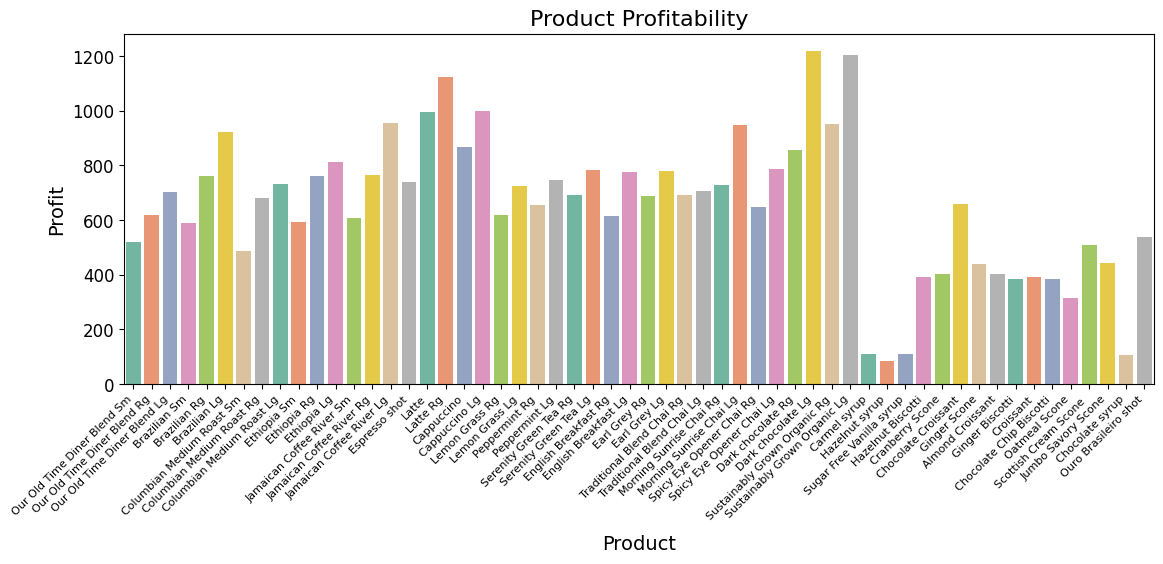

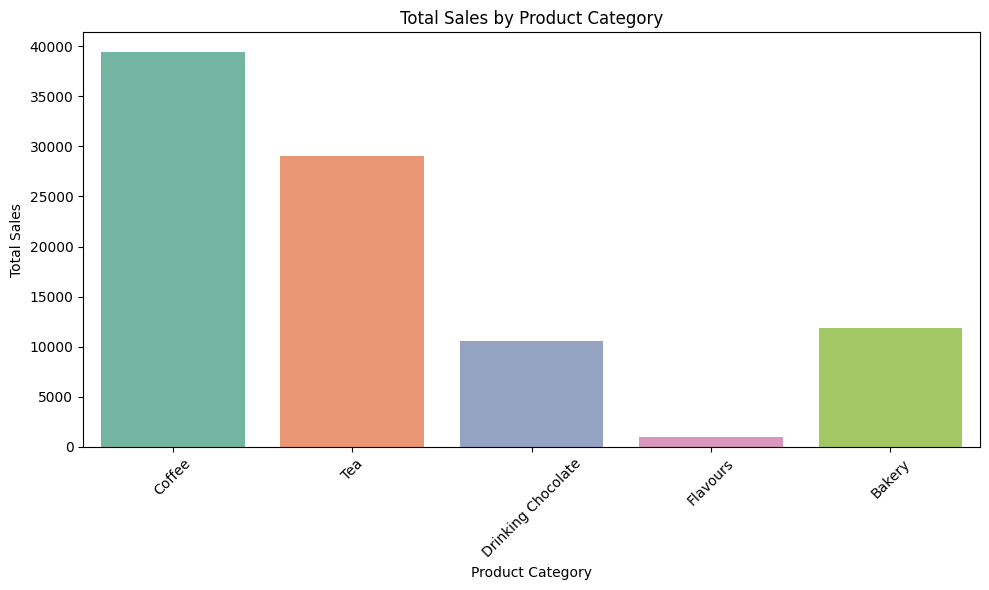

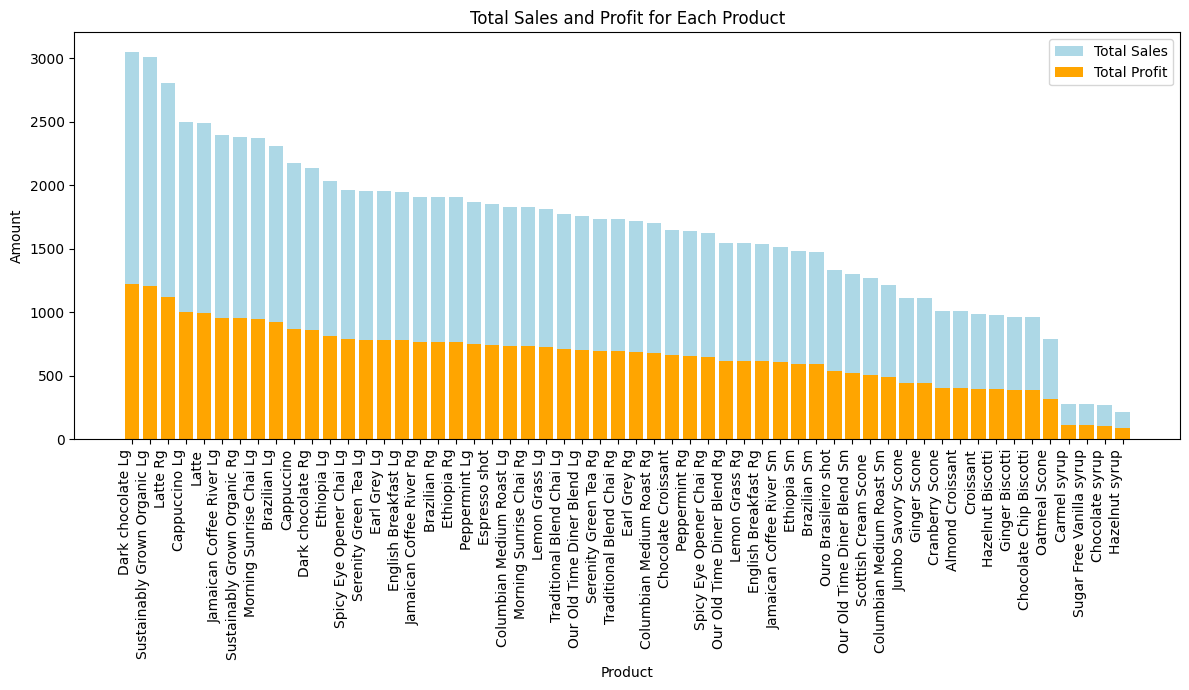

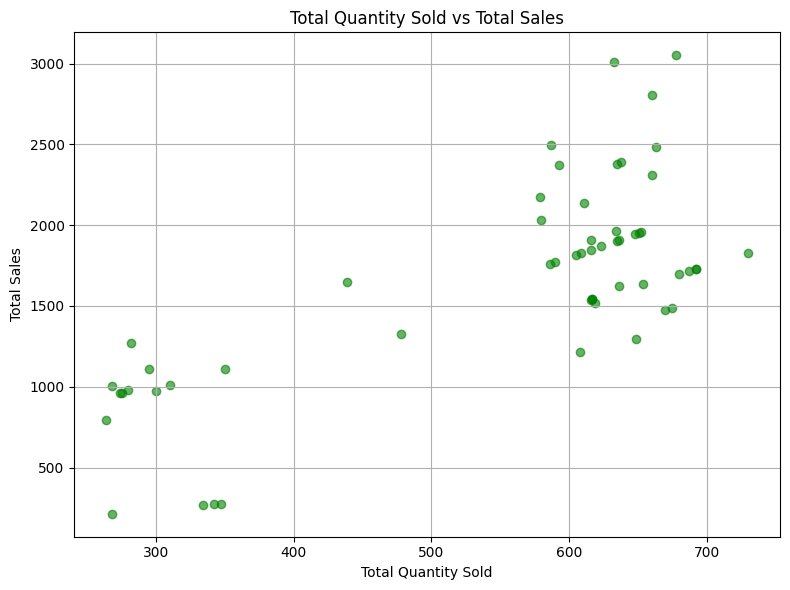

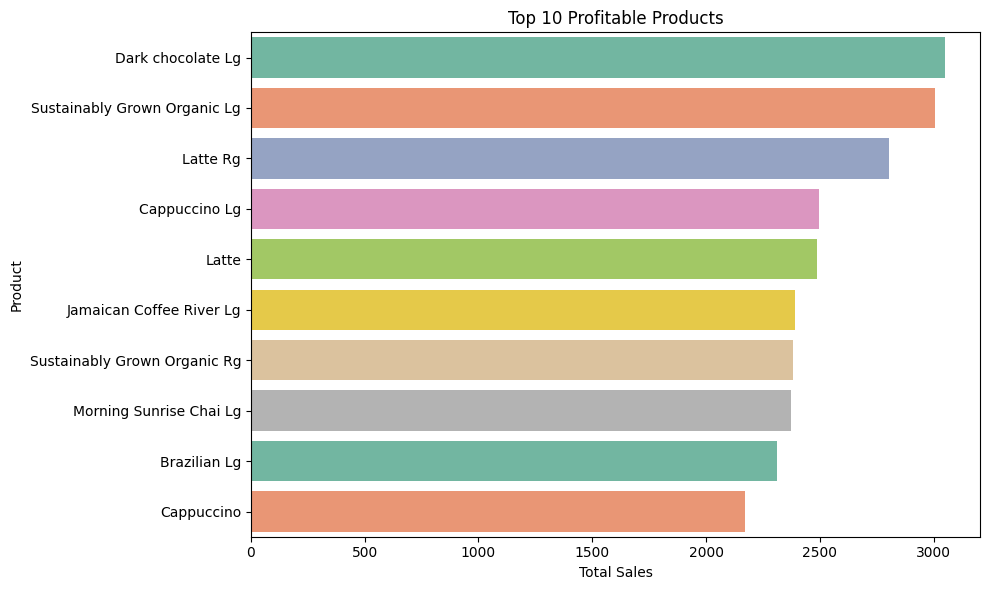

In [2]:
# Step 2: Profit/Loss Analysis

# Calculate total sales
sales_data['total_sales'] = sales_data['transaction_qty'] * sales_data['unit_price']


# Grouping by product details
product_summary = sales_data.groupby(
    ['product_id', 'product_category', 'product_type', 'product_detail']
).agg(
    total_sales=('total_sales', 'sum'),
    unit_price=('unit_price', 'mean'),
    total_qty=('transaction_qty', 'sum')
).reset_index()

# Define cost
# Assuming 60% of unit price
product_summary['cost_per_unit'] = product_summary['unit_price'] * 0.6

# Calculating profit for each product
product_summary['profit'] = product_summary['total_sales'] - (product_summary['cost_per_unit'] * product_summary['total_qty'])

# Calculate total profit
total_profit = product_summary['profit'].sum()
total_profit

# Display the product summary
product_summary

# Calculating loss for each product
product_summary['loss'] = product_summary['cost_per_unit'] * product_summary['total_qty'] - product_summary['total_sales']

# Calculate total loss
total_loss = product_summary['loss'].sum()
total_loss

# Display the product summary
product_summary

# Visualizing product profitability
plt.figure(figsize=(12, 6))
sns.barplot(x='product_detail', y='profit', data=product_summary, palette='Set2')

plt.title('Product Profitability', fontsize=16)
plt.xlabel('Product', fontsize=14, labelpad=10)
plt.ylabel('Profit', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2)
plt.show()

# Visualizing total sales by product category
plt.figure(figsize=(10, 6))
sns.barplot(x='product_category', y='total_sales', data=product_summary, estimator=sum, ci=None, palette='Set2')
plt.title('Total Sales by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for sales and profit per product
plt.figure(figsize=(12, 7))
sorted_summary = product_summary.sort_values(by='total_sales', ascending=False)
plt.bar(sorted_summary['product_detail'], sorted_summary['total_sales'], color='lightblue', label='Total Sales')
plt.bar(sorted_summary['product_detail'], sorted_summary['profit'], color='orange', label='Total Profit')

plt.title('Total Sales and Profit for Each Product')
plt.xlabel('Product')
plt.ylabel('Amount')
plt.xticks(rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Scatter plot for quantity sold vs. total sales
plt.figure(figsize=(8, 6))
plt.scatter(product_summary['total_qty'], product_summary['total_sales'], color='green', alpha=0.6)
plt.title('Total Quantity Sold vs Total Sales')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

# Identifying the most profitable products
product_summary['profitability'] = product_summary['total_sales'].apply(lambda x: 'Profitable' if x > 0 else 'Loss-incurring')

# Displaying top 10 profitable products
top_products = product_summary[product_summary['total_sales'] > 0].nlargest(10, 'total_sales')

plt.figure(figsize=(10, 6))
sns.barplot(x='total_sales', y='product_detail', data=top_products, palette='Set2')
plt.title('Top 10 Profitable Products')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

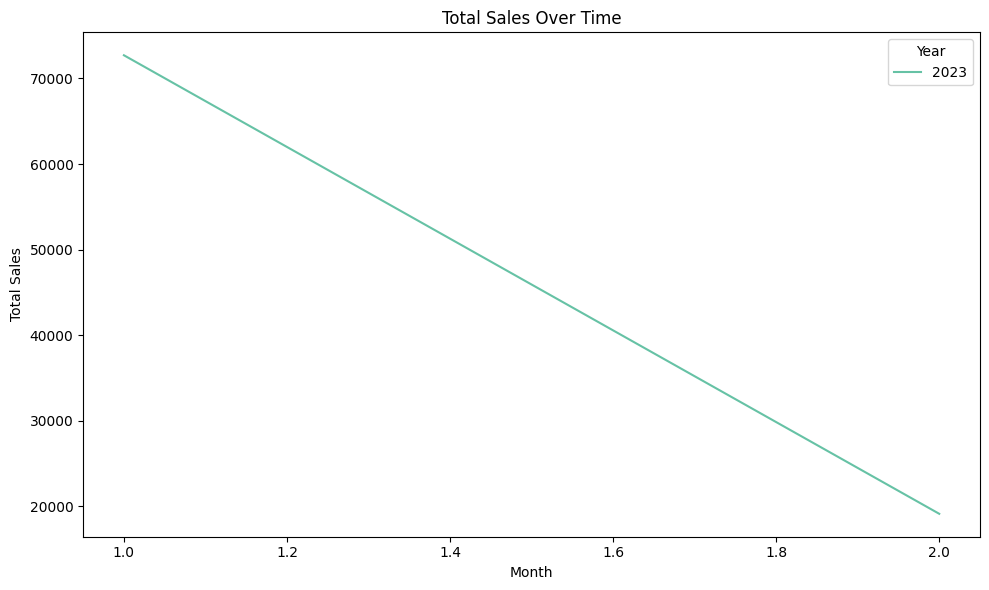

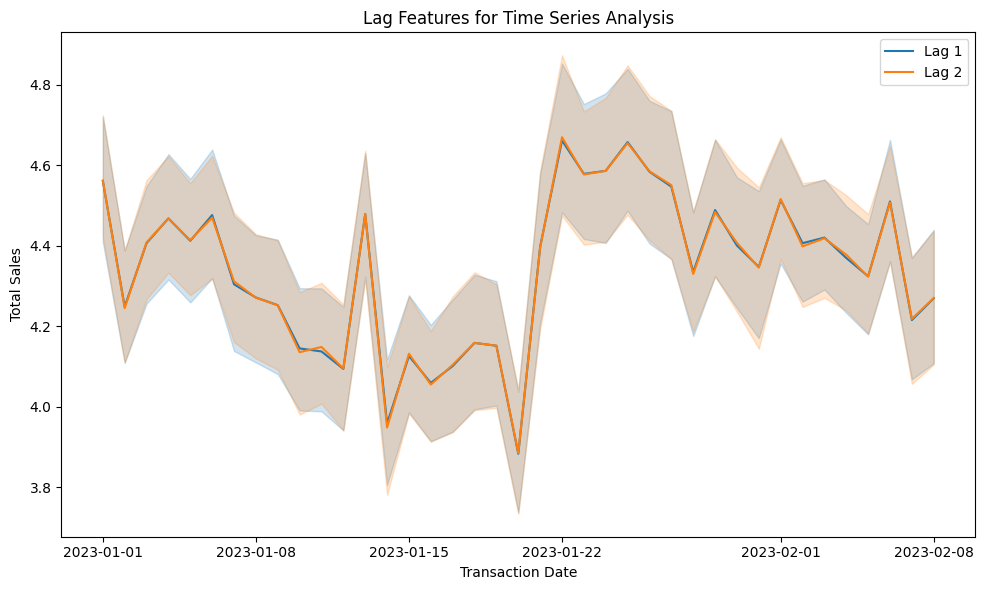

In [3]:
# Creating lag features for time series analysis
sales_data['lag_1'] = sales_data['total_sales'].shift(1)
sales_data['lag_2'] = sales_data['total_sales'].shift(2)
sales_data

# Line chart of total sales over time
sales_data['year'] = sales_data['transaction_date'].dt.year
sales_data['month'] = sales_data['transaction_date'].dt.month
monthly_sales = sales_data.groupby(['year', 'month']).agg(total_sales=('total_sales', 'sum')).reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='total_sales', data=monthly_sales, hue='year', palette='Set2')
plt.title('Total Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

# Visualizing the lag features
plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_date', y='lag_1', data=sales_data, label='Lag 1')
sns.lineplot(x='transaction_date', y='lag_2', data=sales_data, label='Lag 2')
plt.title('Lag Features for Time Series Analysis')
plt.xlabel('Transaction Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


Mean Squared Error (Profit): 3016.610319004302
R-squared (Profit): 0.9541598740616486


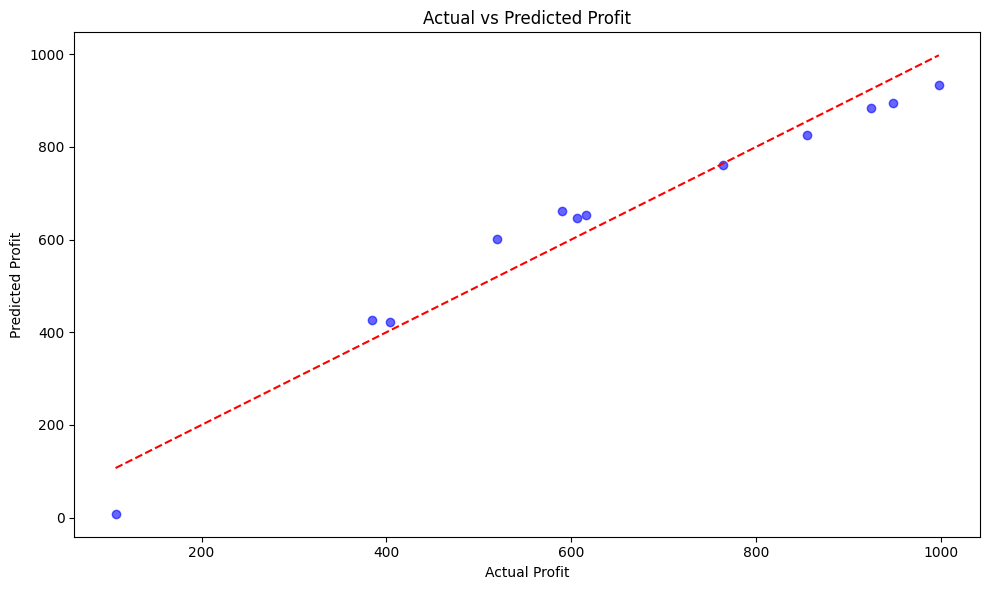

            Coefficient
total_qty      1.196116
unit_price   180.342366


In [4]:
# Step 3: Profit Prediction Model
X_profit = product_summary[['total_qty', 'unit_price']]
y_profit = product_summary['profit']

X_train, X_test, y_train, y_test = train_test_split(X_profit, y_profit, test_size=0.2, random_state=42)

profit_model = LinearRegression()
profit_model.fit(X_train, y_train)

# Making predictions
y_pred = profit_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (Profit): {mse}")
print(f"R-squared (Profit): {r2}")

# Visualizing actual vs predicted profit
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.tight_layout()
plt.show()

# Identifying key factors affecting profitability
coefficients = pd.DataFrame(profit_model.coef_, X_profit.columns, columns=['Coefficient'])
print(coefficients)

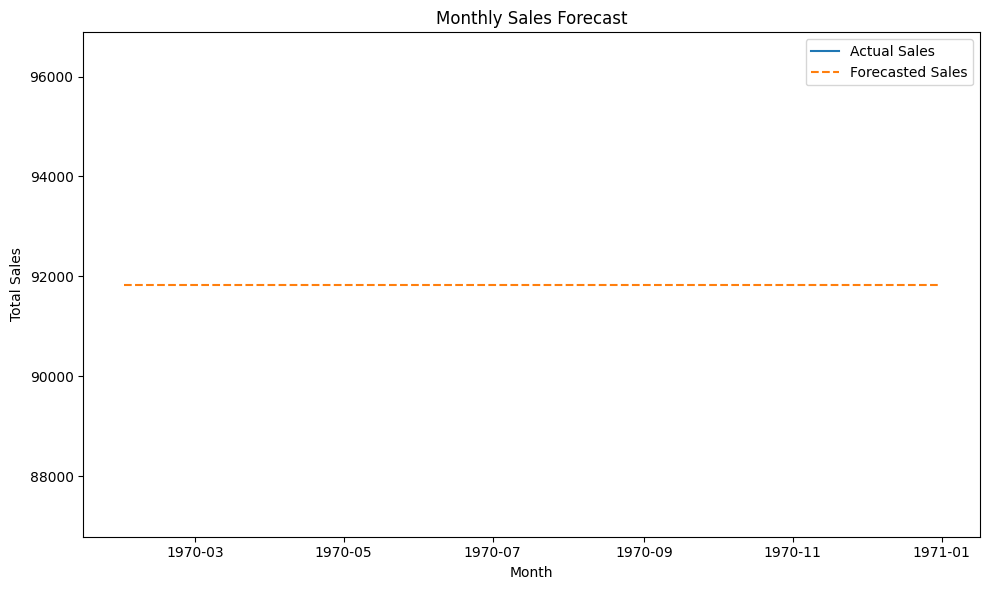

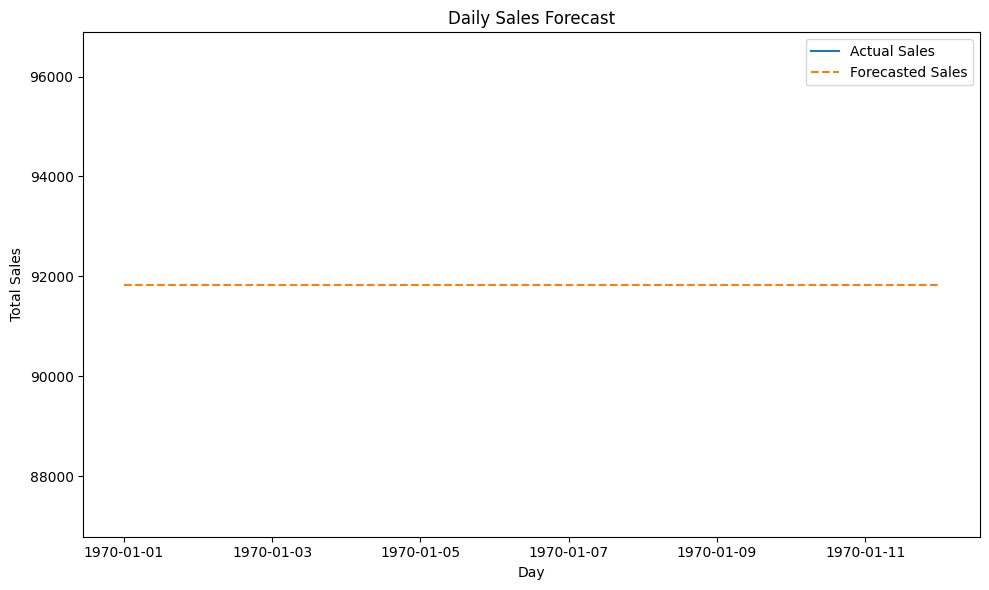

In [5]:
# Time Series Forecasting with ARIMA
sales_data.index = pd.to_datetime(sales_data.index)
monthly_sales = sales_data.select_dtypes(include=[np.number]).resample('M').sum()['total_sales']
daily_sales = sales_data.select_dtypes(include=[np.number]).resample('D').sum()['total_sales']

# Fit the ARIMA model for monthly sales
model_monthly = ARIMA(monthly_sales, order=(1, 1, 1))
model_fit_monthly = model_monthly.fit()

# Fit the ARIMA model for daily sales
model_daily = ARIMA(daily_sales, order=(1, 1, 1))
model_fit_daily = model_daily.fit()


# Forecasting future sales
forecast_steps = 12  # Forecasting for the next 12 months or days
forecast_monthly = model_fit_monthly.forecast(steps=forecast_steps)
forecast_daily = model_fit_daily.forecast(steps=forecast_steps)

# Visualizing the Monthly forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Actual Sales')
plt.plot(pd.date_range(start=monthly_sales.index[-1], periods=forecast_steps, freq='M'), forecast_monthly, label='Forecasted Sales', linestyle='--') # Use forecast_monthly
plt.title('Monthly Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Visualizing the Daily forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales.values, label='Actual Sales')
plt.plot(pd.date_range(start=daily_sales.index[-1], periods=forecast_steps, freq='D'), forecast_daily, label='Forecasted Sales', linestyle='--') # Use forecast_daily
plt.title('Daily Sales Forecast')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

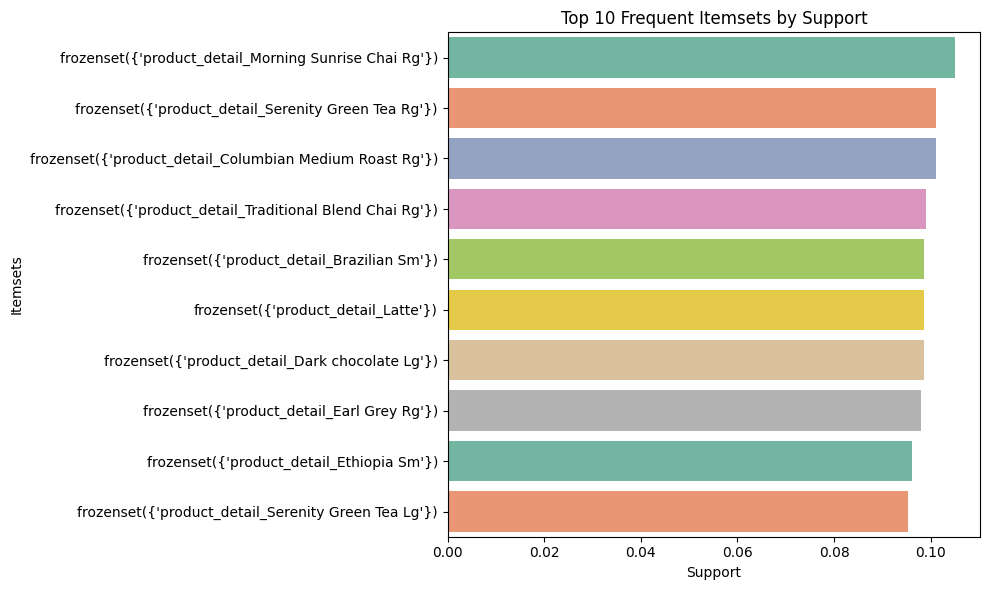

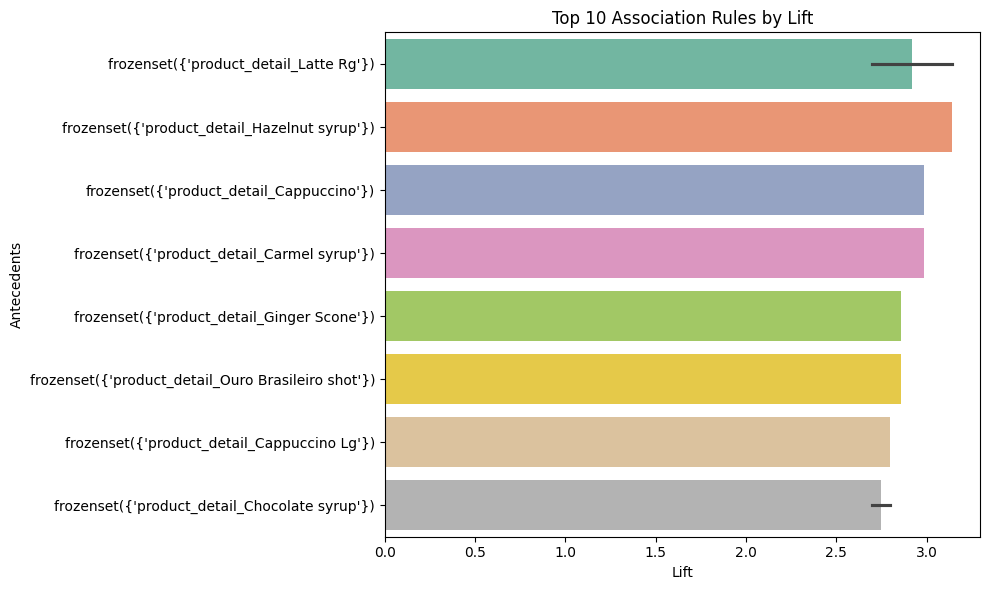

In [6]:
# Market Basket Analysis
# One-Hot Encoding for market basket analysis
basket = pd.get_dummies(sales_data[['customer_id', 'product_detail']], columns=['product_detail']) \
    .groupby(['customer_id']) \
    .sum()

basket[basket > 1] = 1

# Apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True)

# Check if any frequent itemsets are found
if frequent_itemsets.empty:
    # If no frequent itemsets found, lower min_support further
    frequent_itemsets = apriori(basket, min_support=0.001, use_colnames=True)

# Visualize frequent itemsets if found
if not frequent_itemsets.empty:
    plt.figure(figsize=(10, 6)) # Indented this line
    sns.barplot(x='support', y='itemsets', data=frequent_itemsets.sort_values(by='support', ascending=False).head(10), palette='Set2')
    plt.title('Top 10 Frequent Itemsets by Support')
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.tight_layout()
    plt.show()

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Ensure 'lift' column is numeric
rules['lift'] = pd.to_numeric(rules['lift'])

# Visualize association rules by lift
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='antecedents', data=rules.sort_values(by='lift', ascending=False).head(10), palette='Set2')
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Antecedents')
plt.tight_layout()
plt.show()


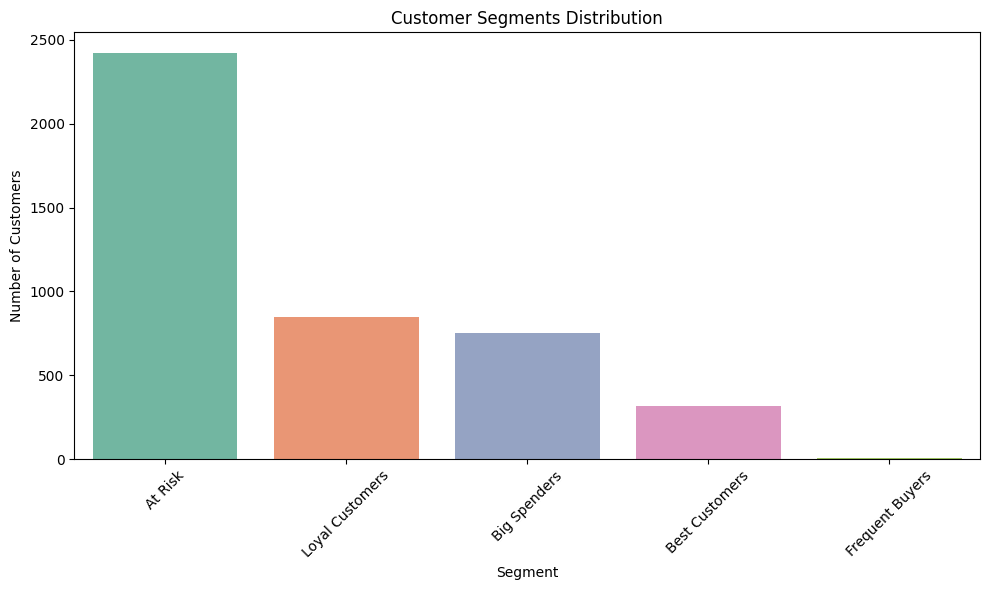

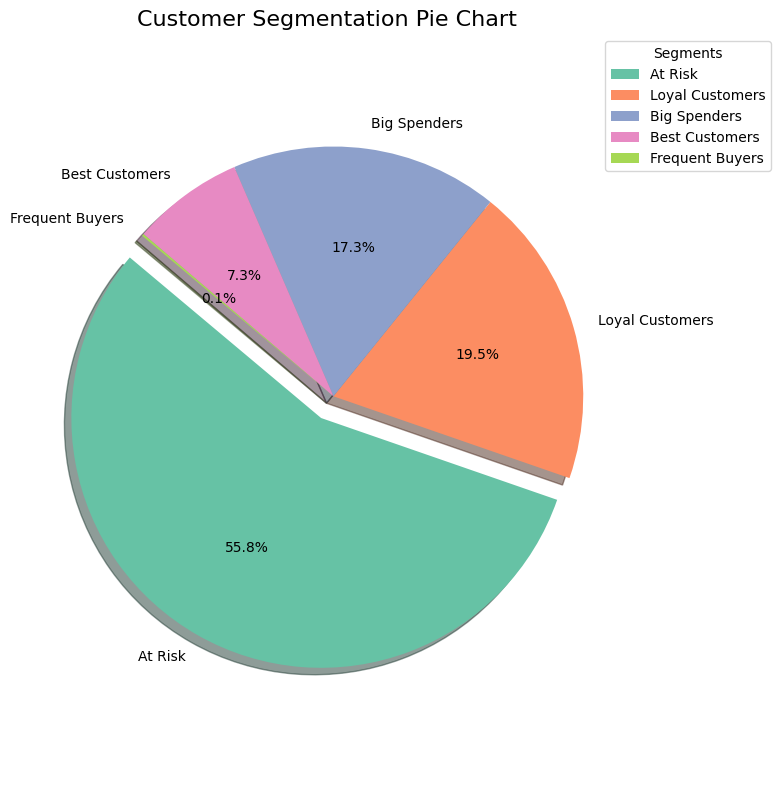

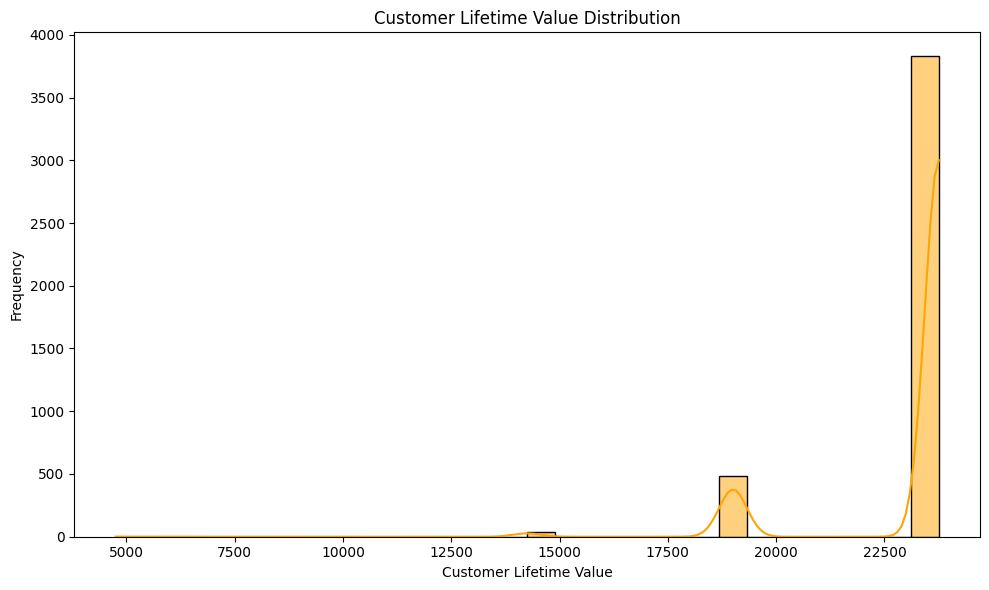

In [10]:
# Customer Segmentation using RFM

# Ensure transaction_date is in datetime format
sales_data['transaction_date'] = pd.to_datetime(sales_data['transaction_date'])
current_date = sales_data['transaction_date'].max() + dt.timedelta(days=1)

# RFM calculation
rfm = sales_data.groupby('customer_id').agg({
    'transaction_date': lambda x: (current_date - x.max()).days,  # Recency
    'transaction_qty': 'count',  # Frequency
    'total_sales': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

def rfm_segment(score):
    if score == '444':
        return 'Best Customers'
    elif score[0] == '4':
        return 'Loyal Customers'
    elif score[1] == '4':
        return 'Frequent Buyers'
    elif score[2] == '4':
        return 'Big Spenders'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(rfm_segment)

# Bar plot for customer segment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x='Segment', palette='Set2', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

segment_counts = rfm['Segment'].value_counts()

# Pie Chart for segment proportion
plt.figure(figsize=(8, 8))
explode = (0.1, 0, 0, 0, 0)
colors = sns.color_palette('Set2', len(segment_counts))
plt.pie(segment_counts,
        labels=segment_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        explode=explode,
        colors=colors,
        shadow=True)
plt.title('Customer Segmentation Pie Chart', fontsize=16)
plt.axis('equal')
plt.legend(segment_counts.index, title="Segments", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

# Calculate Average Order Value
average_order_value = sales_data['total_sales'].mean()

# Assuming average lifespan is estimated (e.g., 3 years)
average_lifespan = 3 * 365  # in days

# Calculate CLV for each customer
rfm['CLV'] = average_order_value * rfm['frequency'] * average_lifespan

# Bar plot for CLV distribution
plt.figure(figsize=(10, 6))
sns.histplot(rfm['CLV'], bins=30, kde=True, color='orange')
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


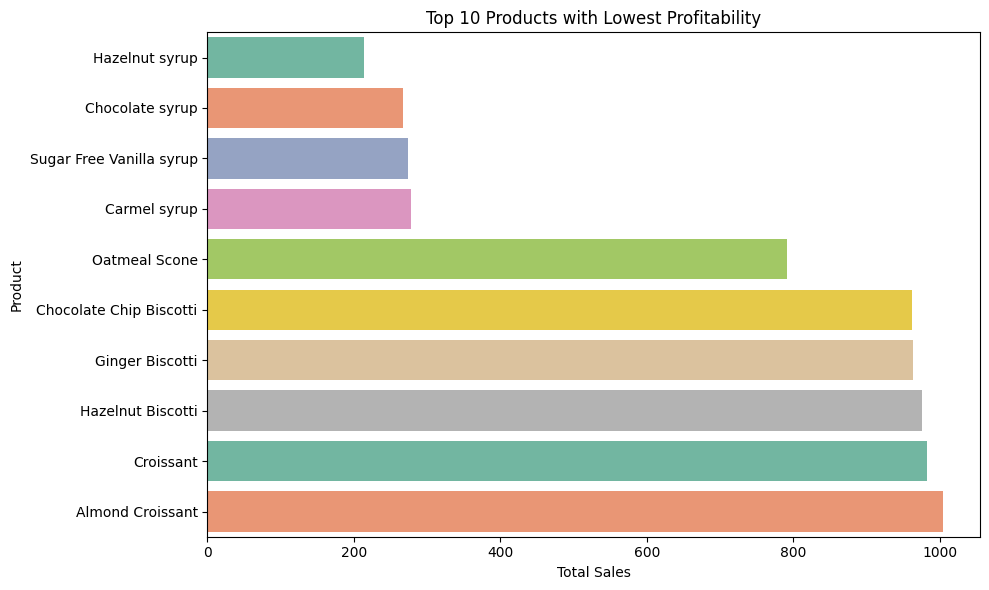

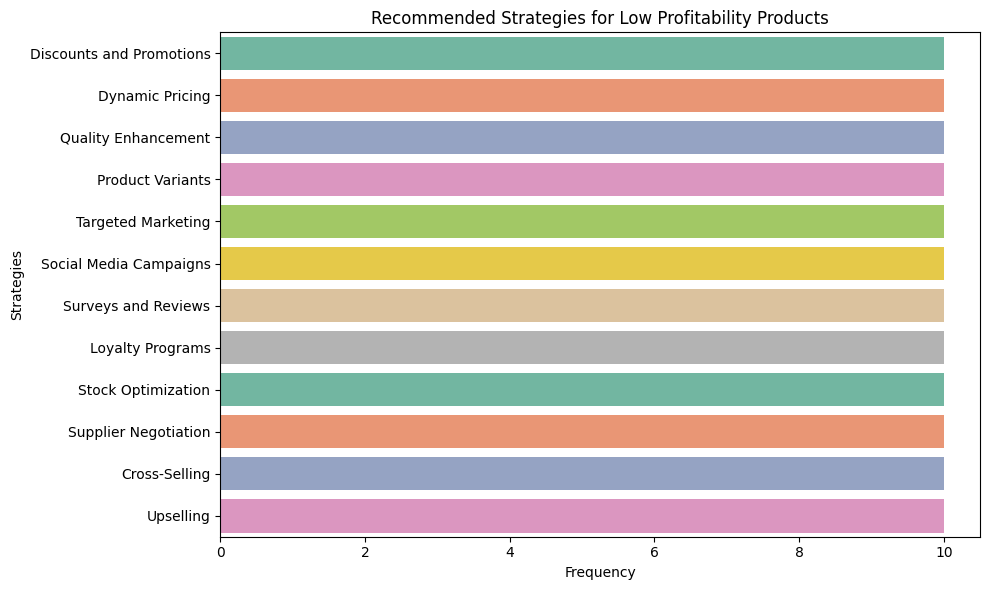

              product_detail  total_sales  \
41            Hazelnut syrup       214.40   
54           Chocolate syrup       267.20   
42  Sugar Free Vanilla syrup       273.60   
40              Carmel syrup       277.60   
51             Oatmeal Scone       792.00   
50   Chocolate Chip Biscotti       962.52   
48           Ginger Biscotti       963.38   
43         Hazelnut Biscotti       976.62   
49                 Croissant       982.64   
47          Almond Croissant      1005.00   

                                           strategies  
41  {'Discounts and Promotions': 'Boost sales volu...  
54  {'Discounts and Promotions': 'Boost sales volu...  
42  {'Discounts and Promotions': 'Boost sales volu...  
40  {'Discounts and Promotions': 'Boost sales volu...  
51  {'Discounts and Promotions': 'Boost sales volu...  
50  {'Discounts and Promotions': 'Boost sales volu...  
48  {'Discounts and Promotions': 'Boost sales volu...  
43  {'Discounts and Promotions': 'Boost sales volu...  


In [14]:
# Step 4: Loss Mitigation

#Identifying Products with Lowest Profitability
lowest_profitability = product_summary.nsmallest(10, 'total_sales')

# Visualizing lowest profitability products
plt.figure(figsize=(10, 6))
sns.barplot(x='total_sales', y='product_detail', data=lowest_profitability, palette='Set2')
plt.title('Top 10 Products with Lowest Profitability')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

# Count occurrences of strategies related to lowest profitability products
strategy_counts = {key: 0 for key in strategies.keys()}

for _, row in lowest_profitability.iterrows():
    for key in strategies.keys():
        strategy_counts[key] += 1

strategy_df = pd.DataFrame(strategy_counts.items(), columns=['Strategy', 'Count'])

# Visualizing strategy counts
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Strategy', data=strategy_df, palette='Set2')
plt.title('Recommended Strategies for Low Profitability Products')
plt.xlabel('Frequency')
plt.ylabel('Strategies')
plt.tight_layout()
plt.show()

# Strategies for improvement
strategies = {
    'Discounts and Promotions': 'Boost sales volume with attractive offers.',
    'Dynamic Pricing': 'Adjust prices based on market conditions.',
    'Quality Enhancement': 'Improve product quality to increase demand.',
    'Product Variants': 'Offer new variations to attract diverse customers.',
    'Targeted Marketing': 'Focus marketing efforts on potential buyers.',
    'Social Media Campaigns': 'Utilize social media for brand awareness.',
    'Surveys and Reviews': 'Gather feedback to identify improvement areas.',
    'Loyalty Programs': 'Create incentives for repeat customers.',
    'Stock Optimization': 'Manage inventory to reduce costs.',
    'Supplier Negotiation': 'Secure better terms from suppliers.',
    'Cross-Selling': 'Encourage purchase of complementary products.',
    'Upselling': 'Motivate customers to choose higher-value items.'
}

lowest_profitability['strategies'] = lowest_profitability['product_detail'].apply(lambda x: strategies)

print(lowest_profitability[['product_detail', 'total_sales', 'strategies']])


# Print actionable steps for each loss-making product

for _, row in lowest_profitability.iterrows():
    product = row['product_detail']
    print(f"\nProduct: {product}")
    print("Actionable Steps:")
    for key, value in strategies.items():
        print(f"- {key}: {value}")